# Regression Analysis Diagnostics Viz

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Data Viz. 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## Generate Sample Data

In [2]:
np.random.seed(42)

def generate_sample_data():
    """Generate sample time series data."""
    df = pd.DataFrame(
        data={'date': pd.date_range(start='2018-01-01', end='2020-12-31', freq='W')}
    )

    n = df.shape[0]

    df['t'] = np.linspace(start=1, stop=n, num=n)
    df['x1'] = np.random.uniform(low=-1.0, high=1.0, size=n)
    df['x1'] = df['x1'].apply(lambda x: x if abs(x) > 0.7 else 0.0)
    df['x2'] = 10*np.log(df['t'])
    df['x3'] = np.random.uniform(low=-1.0, high=1.0, size=n)
    df['x3'] = df['x3'].apply(lambda x: x if abs(x) > 0.95 else 0.0)
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofyear_sc'] = np.sin(2*np.pi*df['dayofyear']/365.5)
    df['dayofyear_cc'] = np.cos(2*np.pi*df['dayofyear']/365.5)
    df['y'] = 10.0 \
         + 20*df['x1'] \
         + df['x2'] \
         + 15*df['dayofyear_sc'] \
         + 5*df['dayofyear_cc'] + \
         + 10*df['x3'] \
         + np.random.normal(loc=0.0, scale=5.0, size=n)

    return df

data_df = generate_sample_data()

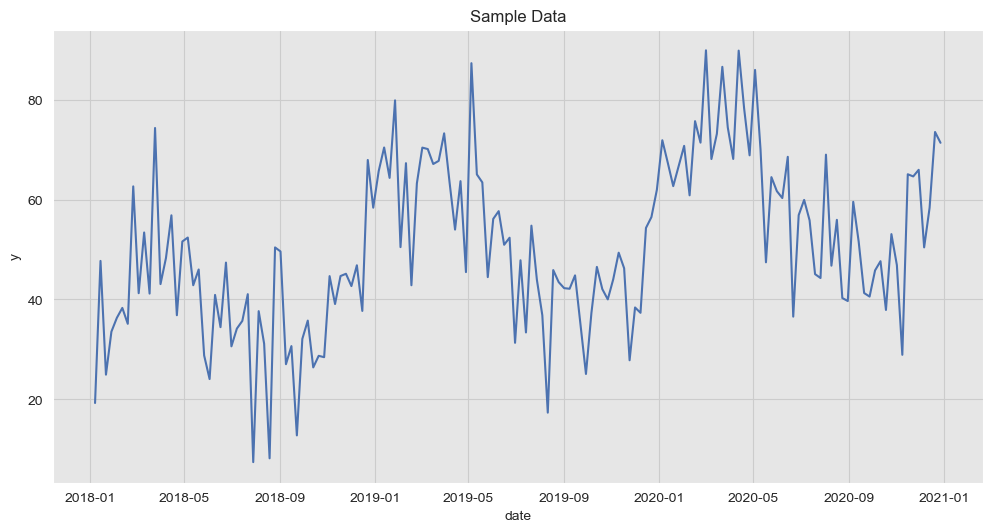

In [3]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', data=data_df, color=sns_c[0], ax=ax)
ax.set(title='Sample Data');

## Train-Test Split

In [4]:
threshold_date = '2020-01-04'

data_train_df = data_df.query(f'date < "{threshold_date}"')
data_test_df = data_df.query(f'date >= "{threshold_date}"')

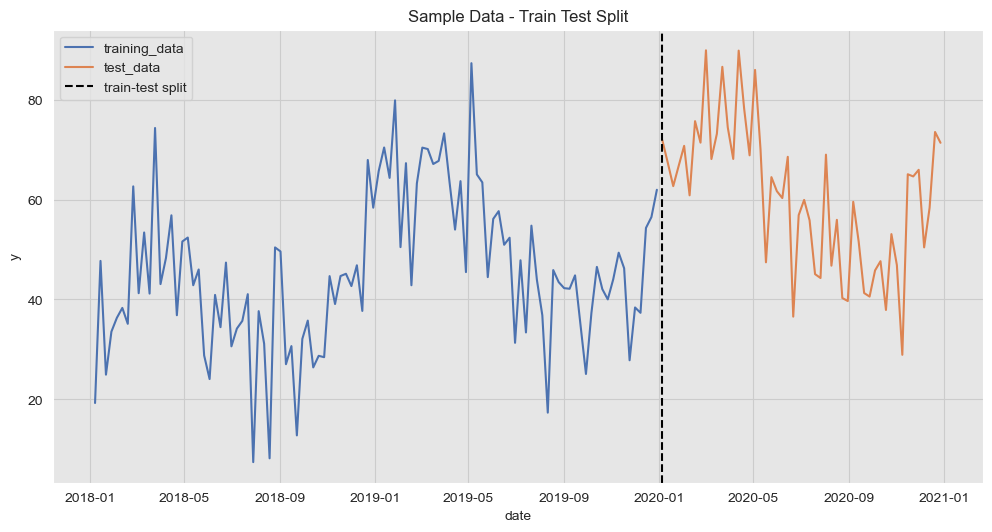

In [5]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', data=data_train_df, color=sns_c[0], label='training_data', ax=ax)
sns.lineplot(x='date', y='y', data=data_test_df, color=sns_c[1], label='test_data', ax=ax)
ax.axvline(threshold_date, color='black', linestyle='--', label='train-test split')
ax.legend(loc='upper left')
ax.set(title='Sample Data - Train Test Split');

## Plot Features

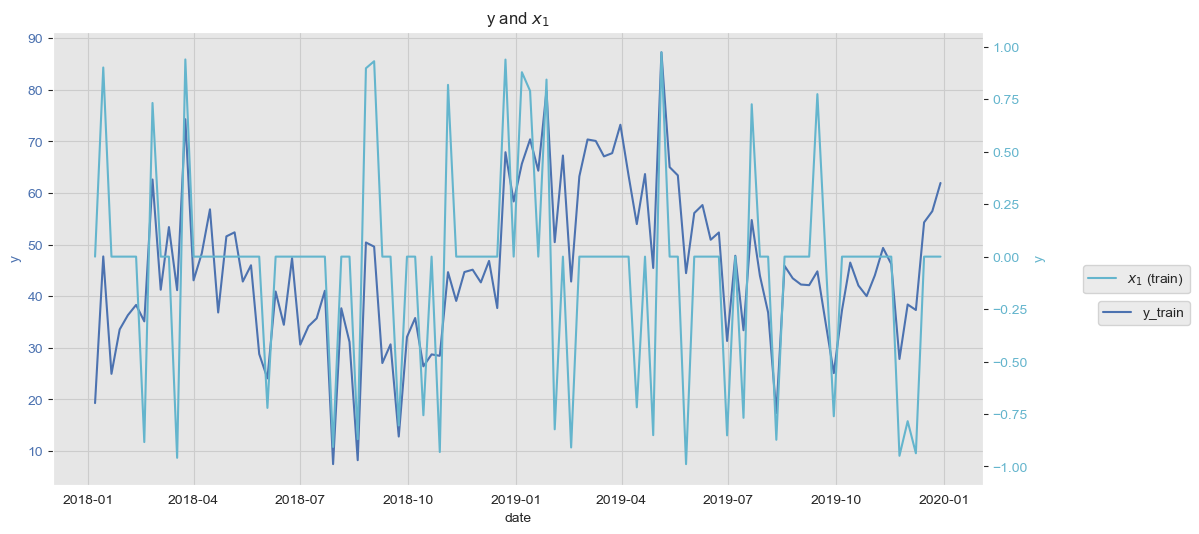

In [6]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
sns.lineplot(x='date', y='y', data=data_train_df, color=sns_c[0], label='y_train', ax=ax1)
sns.lineplot(x='date', y='x1', data=data_train_df, color=sns_c[9], label=f'$x_1$ (train)', ax=ax2)
ax1.legend(bbox_to_anchor=(1.23, 0.42))
ax2.legend(bbox_to_anchor=(1.23, 0.5))
ax1.tick_params(axis='y', labelcolor=sns_c[0])
ax1.set_ylabel('y', fontdict={'color': sns_c[0]})
ax1.set(title=f'y and $x_1$')
ax2.grid(None)
ax2.tick_params(axis='y', labelcolor=sns_c[9])
ax2.set_ylabel('y', fontdict={'color': sns_c[9]});

## Linear Model

In [7]:
model_formula = 'y ~ x1 + x2 + dayofyear_sc + dayofyear_cc'
model = smf.ols(model_formula, data=data_train_df)
result = model.fit()

print(result.summary())

OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     211.6
Date:                Thu, 18 Jun 2020   Prob (F-statistic):           1.39e-47
Time:                        22:38:15   Log-Likelihood:                -312.92
No. Observations:                 104   AIC:                             635.8
Df Residuals:                      99   BIC:                             649.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        9.2593      2.203      4.202      0.000       4.887      13

## Predictions

In [8]:
train_pred_df = result.get_prediction(data_train_df).summary_frame()
train_pred_df.columns = 'pred_' + train_pred_df.columns
train_pred_df = pd.concat([data_train_df, train_pred_df], axis=1)

train_pred_df = train_pred_df.assign(
        error = lambda x: x['pred_mean'] - x['y'],
        abs_error = lambda x: x['error'].abs(),
        p_error = lambda x: x['error'].div(x['y'])
    )

test_pred_df = result.get_prediction(data_test_df).summary_frame()
test_pred_df.columns = 'pred_' + test_pred_df.columns
test_pred_df = pd.concat([data_test_df.reset_index(drop=True), test_pred_df], axis=1)

test_pred_df = test_pred_df.assign(
        error = lambda x: x['pred_mean'] - x['y'],
        abs_error = lambda x: x['error'].abs(),
        p_error = lambda x: x['error'].div(x['y'])
    )

pred_df = pd.concat(
    [train_pred_df.assign(tag='train'), test_pred_df.assign(tag='test')], 
    axis=0
)

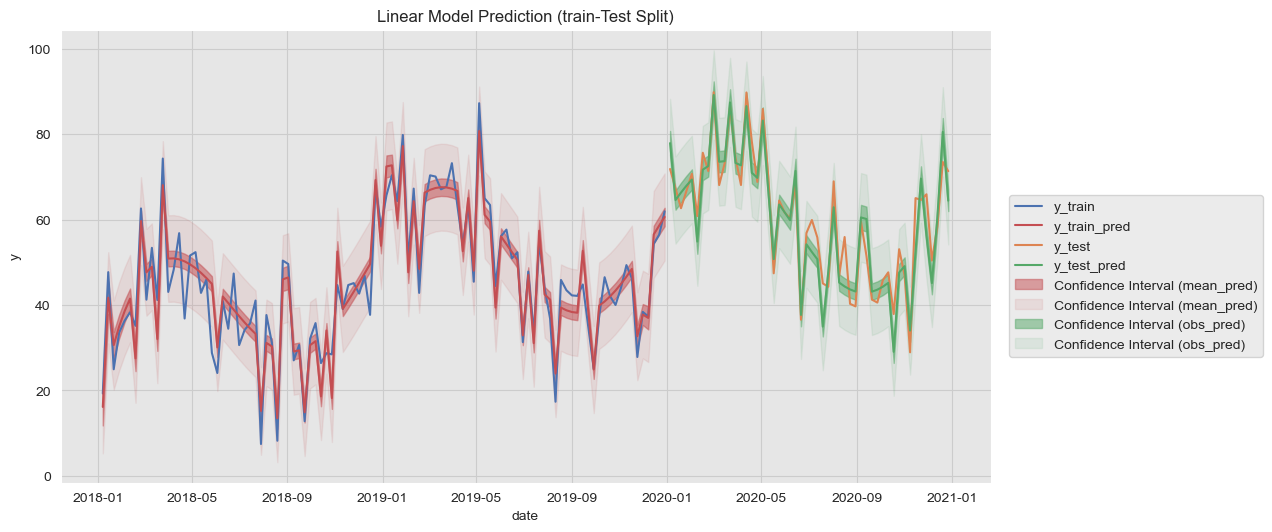

In [9]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', data=train_pred_df, color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x='date', y='pred_mean', data=train_pred_df, color=sns_c[3], label='y_train_pred', ax=ax)
ax.fill_between(
    x=train_pred_df['date'],
    y1=train_pred_df['pred_mean_ci_lower'],
    y2=train_pred_df['pred_mean_ci_upper'],
    color=sns_c[3], 
    alpha=0.5,
    label='Confidence Interval (mean_pred)'
)
ax.fill_between(
    x=train_pred_df['date'],
    y1=train_pred_df['pred_obs_ci_lower'],
    y2=train_pred_df['pred_obs_ci_upper'],
    color=sns_c[3], 
    alpha=0.10,
    label='Confidence Interval (mean_pred)'
)
sns.lineplot(x='date', y='y', data=test_pred_df, color=sns_c[1], label='y_test', ax=ax)
sns.lineplot(x='date', y='pred_mean', data=test_pred_df, color=sns_c[2], label='y_test_pred', ax=ax)
ax.fill_between(
    x=test_pred_df['date'],
    y1=test_pred_df['pred_mean_ci_lower'],
    y2=test_pred_df['pred_mean_ci_upper'],
    color=sns_c[2], 
    alpha=0.5,
    label='Confidence Interval (obs_pred)'
)
ax.fill_between(
    x=test_pred_df['date'],
    y1=test_pred_df['pred_obs_ci_lower'],
    y2=test_pred_df['pred_obs_ci_upper'],
    color=sns_c[2], 
    alpha=0.10,
    label='Confidence Interval (obs_pred)'
)
ax.legend(bbox_to_anchor=(1.3, 0.65))
ax.set(title='Linear Model Prediction (train-Test Split)', ylabel='y');

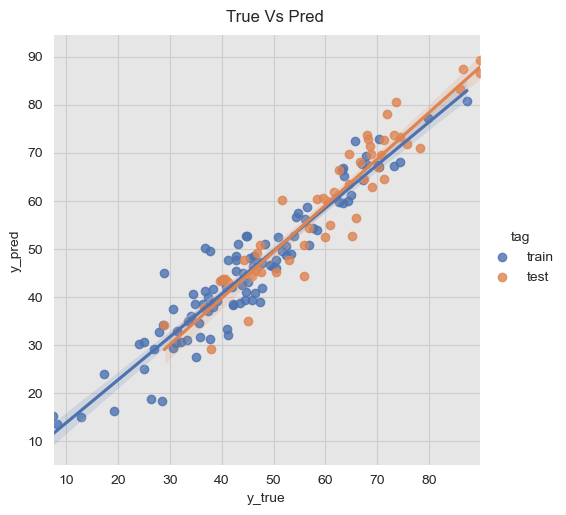

In [10]:
g = sns.lmplot(x='y', y ='pred_mean', data=pred_df, hue='tag')
g.fig.suptitle('True Vs Pred', y=1.02)
g.set_axis_labels('y_true', 'y_pred');

## Error Analysis

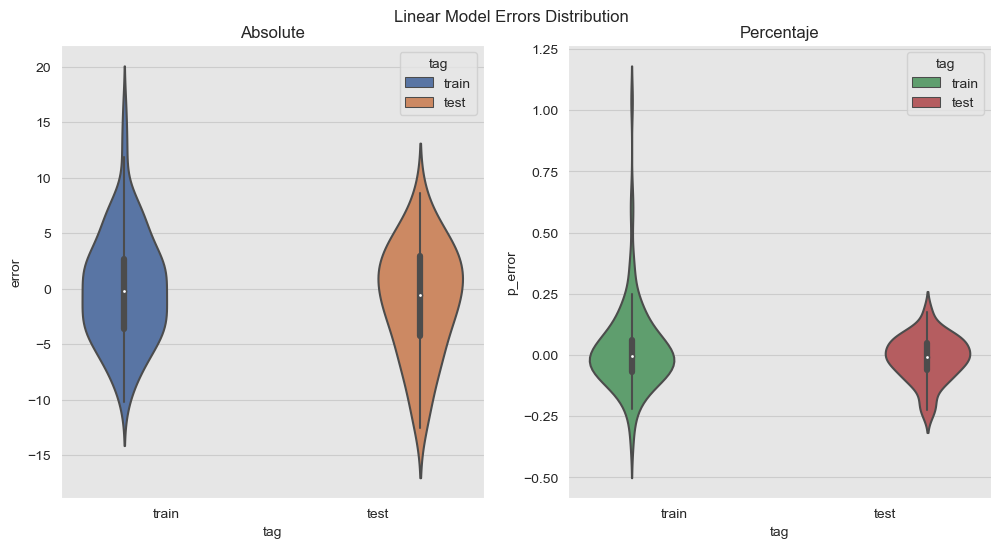

In [15]:
fig, ax = plt.subplots(1, 2)
sns.violinplot(x='tag', y='error', data=pred_df, hue='tag', palette=[sns_c[0], sns_c[1]], ax=ax[0])
sns.violinplot(x='tag', y='p_error', data=pred_df, hue='tag', palette=[sns_c[2], sns_c[3]], ax=ax[1])
ax[0].set(title='Absolute')
ax[1].set(title='Percentaje')
plt.suptitle(f'Linear Model Errors Distribution', y=0.94);


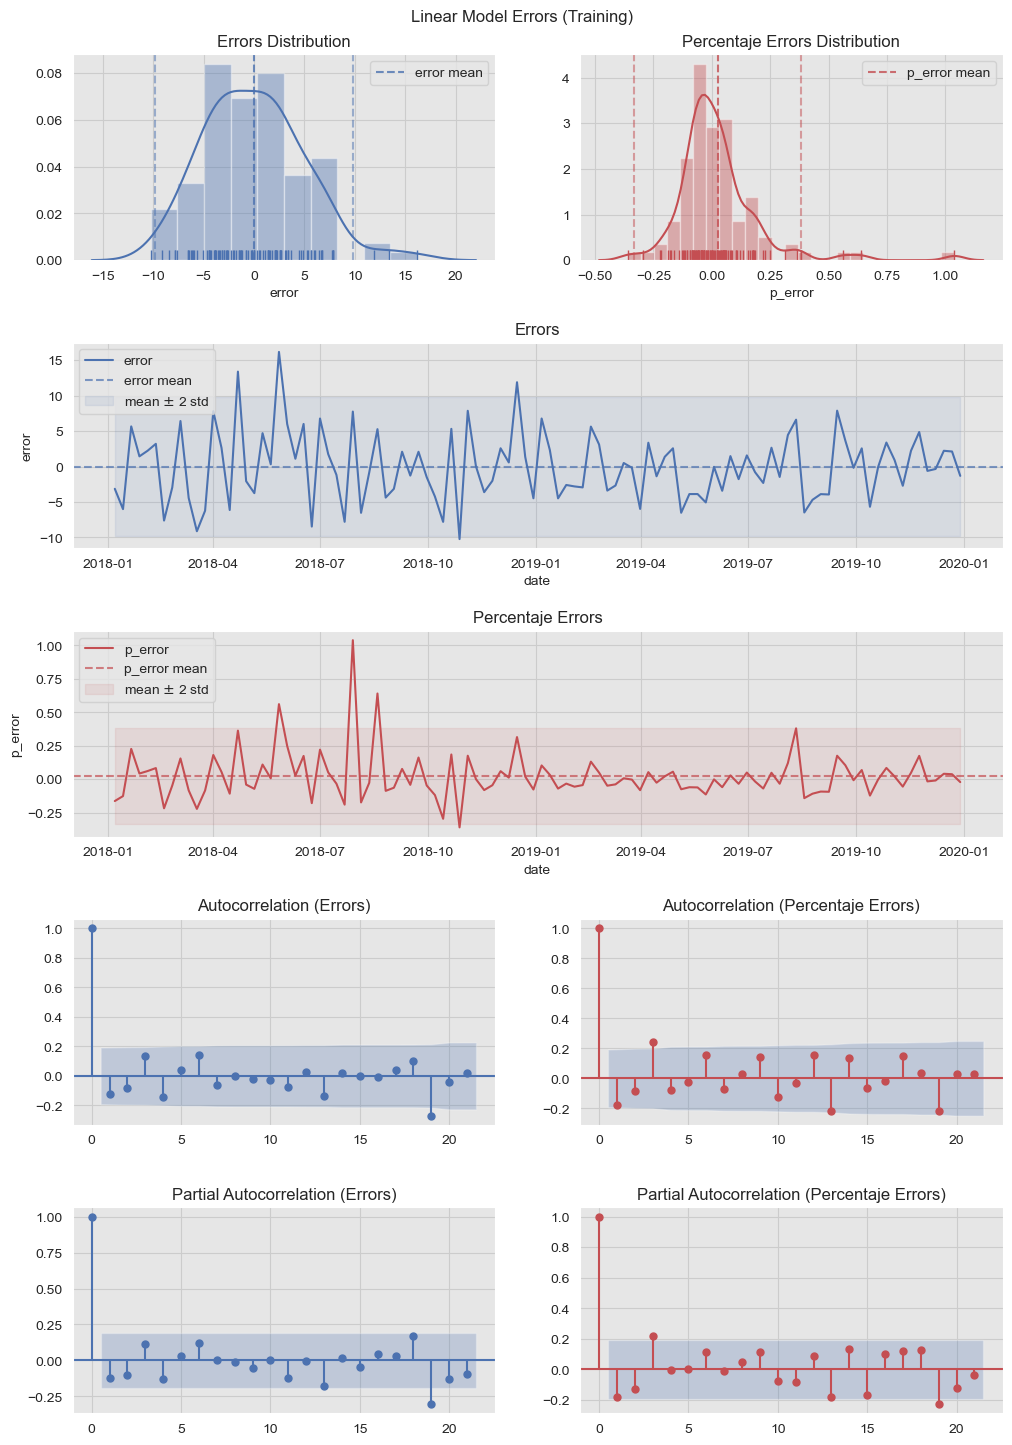

In [12]:
# Linear Model Error Plots. 
# Compute Errors Metrics.
error_mean = train_pred_df['error'].mean()
error_std = train_pred_df['error'].std()
p_error_mean = train_pred_df['p_error'].mean()
p_error_std = train_pred_df['p_error'].std()
# Define plot grid.
fig = plt.figure(figsize=(12, 18), constrained_layout=True)
grid = plt.GridSpec(5, 2, hspace=0.4)
ax00 = fig.add_subplot(grid[0, 0])
ax01 = fig.add_subplot(grid[0, 1])
ax1 = fig.add_subplot(grid[1, :2])
ax2 = fig.add_subplot(grid[2, :2])
ax30 = fig.add_subplot(grid[3, 0])
ax31 = fig.add_subplot(grid[3, 1])
ax40 = fig.add_subplot(grid[4, 0])
ax41 = fig.add_subplot(grid[4, 1])
# Add data.
sns.distplot(a=train_pred_df['error'], color=sns_c[0], rug=True, ax=ax00)
ax00.axvline(x=error_mean, color=sns_c[0], linestyle='--', label='error mean', alpha=0.8)
ax00.axvline(x=error_mean + 2*error_std, color=sns_c[0], linestyle='--', alpha=0.5)
ax00.axvline(x=error_mean - 2*error_std, color=sns_c[0], linestyle='--', alpha=0.5)
sns.distplot(a=train_pred_df['p_error'], color=sns_c[3], rug=True, ax=ax01)
ax01.axvline(x=p_error_mean , color=sns_c[3], linestyle='--', label='p_error mean', alpha=0.8)
ax01.axvline(x=p_error_mean + 2*p_error_std, color=sns_c[3], linestyle='--', alpha=0.5)
ax01.axvline(x=p_error_mean - 2*p_error_std, color=sns_c[3], linestyle='--', alpha=0.5)
sns.lineplot(x='date', y='error', data=train_pred_df, color=sns_c[0], label='error', ax=ax1)
ax1.axhline(y=error_mean, color=sns_c[0], linestyle='--', label='error mean', alpha=0.7)
ax1.fill_between(
    x=train_pred_df['date'], 
    y1=error_mean - 2*error_std, 
    y2=error_mean + 2*error_std,
    color=sns_c[0],
    alpha=0.1,
    label=r'mean $\pm$ 2 std'
)
sns.lineplot(x='date', y='p_error', data=train_pred_df, color=sns_c[3], label='p_error', ax=ax2)
ax2.axhline(y=p_error_mean , color=sns_c[3], linestyle='--', label='p_error mean', alpha=0.7)
ax2.fill_between(
    x=train_pred_df['date'], 
    y1=p_error_mean - 2*p_error_std, 
    y2=p_error_mean + 2*p_error_std,
    color=sns_c[3],
    alpha=0.1,
    label=r'mean $\pm$ 2 std'
)
plot_acf(x=train_pred_df['error'], vlines_kwargs={'color': sns_c[0]}, color=sns_c[0], ax=ax30)
plot_acf(x=train_pred_df['p_error'], vlines_kwargs={'color': sns_c[3]}, color=sns_c[3], ax=ax31)
plot_pacf(x=train_pred_df['error'], vlines_kwargs={'color': sns_c[0]}, color=sns_c[0], ax=ax40)
plot_pacf(x=train_pred_df['p_error'], vlines_kwargs={'color': sns_c[3]}, color=sns_c[3], ax=ax41)
# Customization.
ax00.legend(loc='upper right')
ax00.set(title='Errors Distribution')
ax01.legend(loc='upper right')
ax01.set(title='Percentaje Errors Distribution')
ax1.legend(loc='upper left')
ax1.set(title='Errors')
ax2.legend(loc='upper left')
ax2.set(title='Percentaje Errors')
ax30.set(title='Autocorrelation (Errors)')
ax31.set(title='Autocorrelation (Percentaje Errors)')
ax40.set(title='Partial Autocorrelation (Errors)')
ax41.set(title='Partial Autocorrelation (Percentaje Errors)')
plt.suptitle(f'Linear Model Errors (Training)', y=0.905);

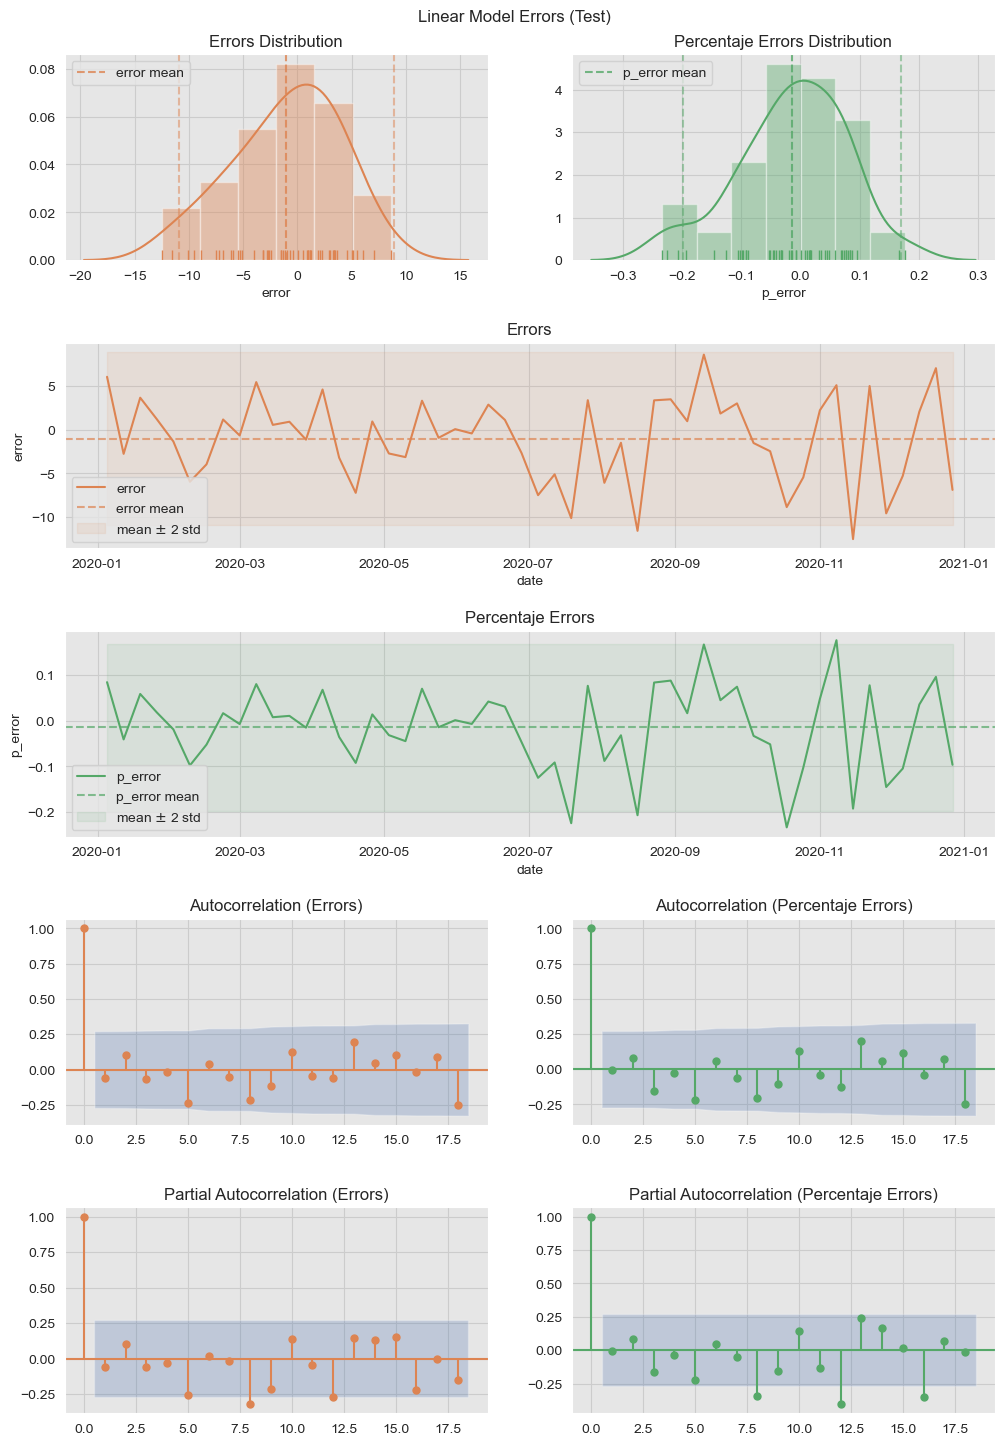

In [13]:
# Linear Model Error Plots.
# Compute Errors Metrics.
error_mean = test_pred_df['error'].mean()
error_std = test_pred_df['error'].std()
p_error_mean = test_pred_df['p_error'].mean()
p_error_std = test_pred_df['p_error'].std()
# Define plot grid.
fig = plt.figure(figsize=(12, 18), constrained_layout=True)
grid = plt.GridSpec(5, 2, hspace=0.4)
ax00 = fig.add_subplot(grid[0, 0])
ax01 = fig.add_subplot(grid[0, 1])
ax1 = fig.add_subplot(grid[1, :2])
ax2 = fig.add_subplot(grid[2, :2])
ax30 = fig.add_subplot(grid[3, 0])
ax31 = fig.add_subplot(grid[3, 1])
ax40 = fig.add_subplot(grid[4, 0])
ax41 = fig.add_subplot(grid[4, 1])
# Add data.
sns.distplot(a=test_pred_df['error'], color=sns_c[1], rug=True, ax=ax00)
ax00.axvline(x=error_mean, color=sns_c[1], linestyle='--', label='error mean', alpha=0.8)
ax00.axvline(x=error_mean + 2*error_std, color=sns_c[1], linestyle='--', alpha=0.5)
ax00.axvline(x=error_mean - 2*error_std, color=sns_c[1], linestyle='--', alpha=0.5)
sns.distplot(a=test_pred_df['p_error'], color=sns_c[2], rug=True, ax=ax01)
ax01.axvline(x=p_error_mean , color=sns_c[2], linestyle='--', label='p_error mean', alpha=0.8)
ax01.axvline(x=p_error_mean + 2*p_error_std, color=sns_c[2], linestyle='--', alpha=0.5)
ax01.axvline(x=p_error_mean - 2*p_error_std, color=sns_c[2], linestyle='--', alpha=0.5)
sns.lineplot(x='date', y='error', data=test_pred_df, color=sns_c[1], label='error', ax=ax1)
ax1.axhline(y=error_mean, color=sns_c[1], linestyle='--', label='error mean', alpha=0.7)
ax1.fill_between(
    x=test_pred_df['date'], 
    y1=error_mean - 2*error_std, 
    y2=error_mean + 2*error_std,
    color=sns_c[1],
    alpha=0.1,
    label=r'mean $\pm$ 2 std'
)
sns.lineplot(x='date', y='p_error', data=test_pred_df, color=sns_c[2], label='p_error', ax=ax2)
ax2.axhline(y=p_error_mean , color=sns_c[2], linestyle='--', label='p_error mean', alpha=0.7)
ax2.fill_between(
    x=test_pred_df['date'], 
    y1=p_error_mean - 2*p_error_std, 
    y2=p_error_mean + 2*p_error_std,
    color=sns_c[2],
    alpha=0.1,
    label=r'mean $\pm$ 2 std'
)
plot_acf(x=test_pred_df['error'], vlines_kwargs={'color': sns_c[1]}, color=sns_c[1], ax=ax30)
plot_acf(x=test_pred_df['p_error'], vlines_kwargs={'color': sns_c[2]}, color=sns_c[2], ax=ax31)
plot_pacf(x=test_pred_df['error'], vlines_kwargs={'color': sns_c[1]}, color=sns_c[1], ax=ax40)
plot_pacf(x=test_pred_df['p_error'], vlines_kwargs={'color': sns_c[2]}, color=sns_c[2], ax=ax41)
# Customization.
ax00.legend(loc='upper left')
ax00.set(title='Errors Distribution')
ax01.legend(loc='upper left')
ax01.set(title='Percentaje Errors Distribution')
ax1.legend(loc='lower left')
ax1.set(title='Errors')
ax2.legend(loc='lower left')
ax2.set(title='Percentaje Errors')
ax30.set(title='Autocorrelation (Errors)')
ax31.set(title='Autocorrelation (Percentaje Errors)')
ax40.set(title='Partial Autocorrelation (Errors)')
ax41.set(title='Partial Autocorrelation (Percentaje Errors)')
plt.suptitle(f'Linear Model Errors (Test)', y=0.905);

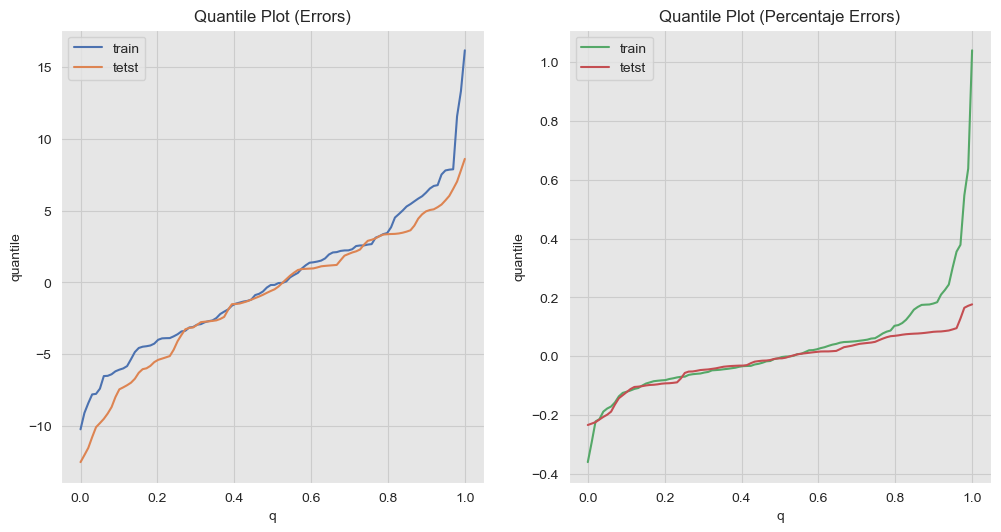

In [14]:
q_grid = np.linspace(start=0.0, stop=1.0, num=100)
train_error_quantiles = np.quantile(a=train_pred_df['error'], q=q_grid)
test_error_quantiles = np.quantile(a=test_pred_df['error'], q=q_grid)
train_p_error_quantiles = np.quantile(a=train_pred_df['p_error'], q=q_grid)
test_p_error_quantiles = np.quantile(a=test_pred_df['p_error'], q=q_grid)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.lineplot(x=q_grid, y=train_error_quantiles, color=sns_c[0], label='train', ax=ax[0])
sns.lineplot(x=q_grid, y=test_error_quantiles, color=sns_c[1], label='tetst', ax=ax[0])
sns.lineplot(x=q_grid, y=train_p_error_quantiles, color=sns_c[2], label='train', ax=ax[1])
sns.lineplot(x=q_grid, y=test_p_error_quantiles, color=sns_c[3], label='tetst', ax=ax[1])
ax[0].legend(loc='upper left')
ax[0].set(title='Quantile Plot (Errors)', xlabel='q', ylabel='quantile')
ax[1].legend(loc='upper left')
ax[1].set(title='Quantile Plot (Percentaje Errors)', xlabel='q', ylabel='quantile');